# MODELING COVID-19

This Jupyter notebook contains a series of visualizations that I hope will help scientists, public officials, business owners, and individuals track the progress of the pandemic as they evaluate which next steps to take.

Designed for Professor Kimball's Information Design Course - Spring 2020

* Data Source: Johns Hopkins Center for Systems Science and Engineering
* Based on [Tarun Kumar's COVID-19 Kaggle Kernel](https://www.kaggle.com/tarunkr/covid-19-case-study-analysis-viz-comparisons)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import folium
import branca
import plotly.express as px
import json, requests
import calmap
import datetime
import geopandas
import shapely

# Matplotlib 
%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize":(20,10),
        "font.sans-serif": "Helvetica",
        "font.weight": "bold",
        "font.size": 22
    })

In [2]:
# Timeseries data for all countries
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [3]:
# Latest up to date COVID-19 for all countries
df_covid_latest = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")

In [4]:
# Rename Country columns so that all columns have consistant naming convention
# Source: https://www.kaggle.com/tarunkr/covid-19-case-study-analysis-viz-comparisons
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "Country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "Country"})
df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "Country"})
df_covid_latest = df_covid_latest.rename(columns={"Country_Region": "Country"})

In [5]:
# Add continent data to each dataframe
# Modified from: https://www.kaggle.com/tarunkr/covid-19-case-study-analysis-viz-comparisons
def rename_country(dataframe,countries):
    for country in countries:
        dataframe.loc[dataframe['Country'] == country, "Country"] = countries[country]

mapping = {'US':'USA','Korea, South':'South Korea','Taiwan*':'Taiwan','Congo (Kinshasa)':'Democratic Republic of the Congo',"Cote d'Ivoire":"Côte d'Ivoire","Reunion":"Réunion","Congo (Brazzaville)":"Republic of the Congo","Bahamas, The":"Bahamas","Gambia, The":"Gambia"}
rename_country(df_confirmed,mapping)
rename_country(df_deaths,mapping)
rename_country(df_recovered,mapping)
rename_country(df_covid_latest,mapping)

# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

# Collecting Continent Information
df_confirmed['Continent'] = df_confirmed['Country'].apply(lambda country: continents[country_to_continent_code(country)])
df_deaths['Continent'] = df_deaths['Country'].apply(lambda country: continents[country_to_continent_code(country)])
df_recovered['Continent'] = df_recovered['Country'].apply(lambda country: continents[country_to_continent_code(country)])
df_covid_latest['Continent'] = df_covid_latest['Country'].apply(lambda country: continents[country_to_continent_code(country)])


## Latest COVID-19 Statistics

In [7]:
# Plot current snapshot of COVID-19 data
def plot_bar(dataframe,dimensions='Country',measure='Mortality_Rate',x_axis='Country',y_axis='Moratliy Rate (%)',title='Morality Rate By Country',color='r'):
    # Global Summary
    dataframe = dataframe.sort_values(by=measure,ascending=False).head(7)
    fig, ax = plt.subplots()
    ax.set_ylabel(y_axis,labelpad=20)
    ax.set_title(title,pad=20)
    ax.set_xlabel(x_axis,labelpad=20)
    dimension_labels = list(dataframe.index)
    measure_values = list(dataframe[measure].values)
    ax.bar(dimension_labels,measure_values,color=color)
    fig.autofmt_xdate()
    plt.show()

# Apply a color map to a dataframe
def style(dataframe,sortby='Confirmed'):
    return dataframe.sort_values(by=sortby,ascending=False).head(7).style.set_precision(2).background_gradient(cmap='Blues',subset=["Confirmed"])\
                            .background_gradient(cmap='Purples',subset=["Deaths"])\
                            .background_gradient(cmap='Oranges',subset=["Recovered"])\
                            .background_gradient(cmap='Reds',subset=["Active"])\
                            .background_gradient(cmap='Blues',subset=["Incident_Rate"])\
                            .background_gradient(cmap='Purples',subset=["Mortality_Rate"])

# Generate an aggegate dataframe given a dimension and measure
# Currently supports two dimensions: Continent, Country
def generate(dataframe,dimension='Continent'):
    drop_column = 'Country'
    if dimension=='Country':
        drop_column = 'Continent'
    dataframe_ = dataframe.copy().drop(['Lat','Long_','UID','ISO3','People_Hospitalized','People_Tested','Last_Update','Mortality_Rate',drop_column],axis=1)
    dataframe_.fillna(0,inplace=True)
    dataframe_ = dataframe_.groupby(dimension).sum()
    
    # Mortality_Rate - Number recorded deaths * 100/ Number confirmed cases.
    dataframe_["Mortality_Rate"] = np.round(100*dataframe_["Deaths"]/dataframe_["Confirmed"],2)
    
    #Incident_Rate - confirmed cases per 100,000 persons.
    dataframe_["Incident_Rate"] = np.round(dataframe_["Confirmed"]/100000,2)
    return dataframe_

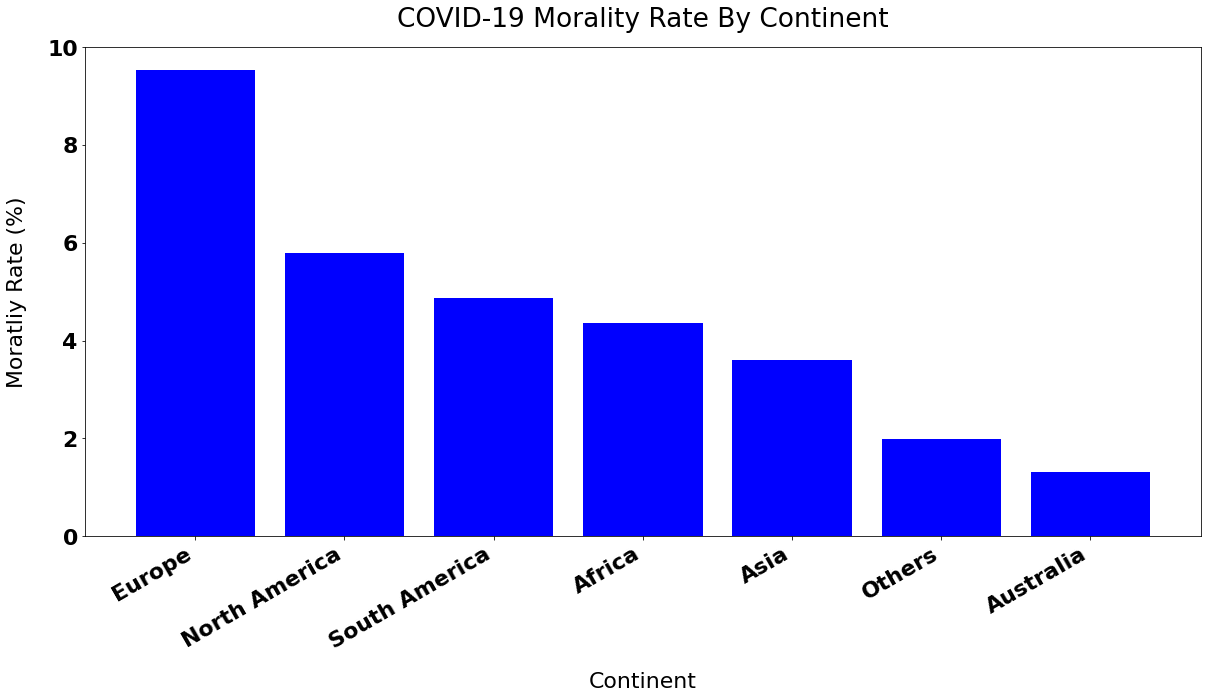

In [33]:
# Create bar charts expressing the latest COVID-19 statistics for each continent
df_continents = generate(df_covid_latest,dimension='Continent')
plot_bar(df_continents,dimensions='Continent',measure='Mortality_Rate',x_axis='Continent',y_axis='Moratliy Rate (%)',title='COVID-19 Morality Rate By Continent',color='b')

Figure 1

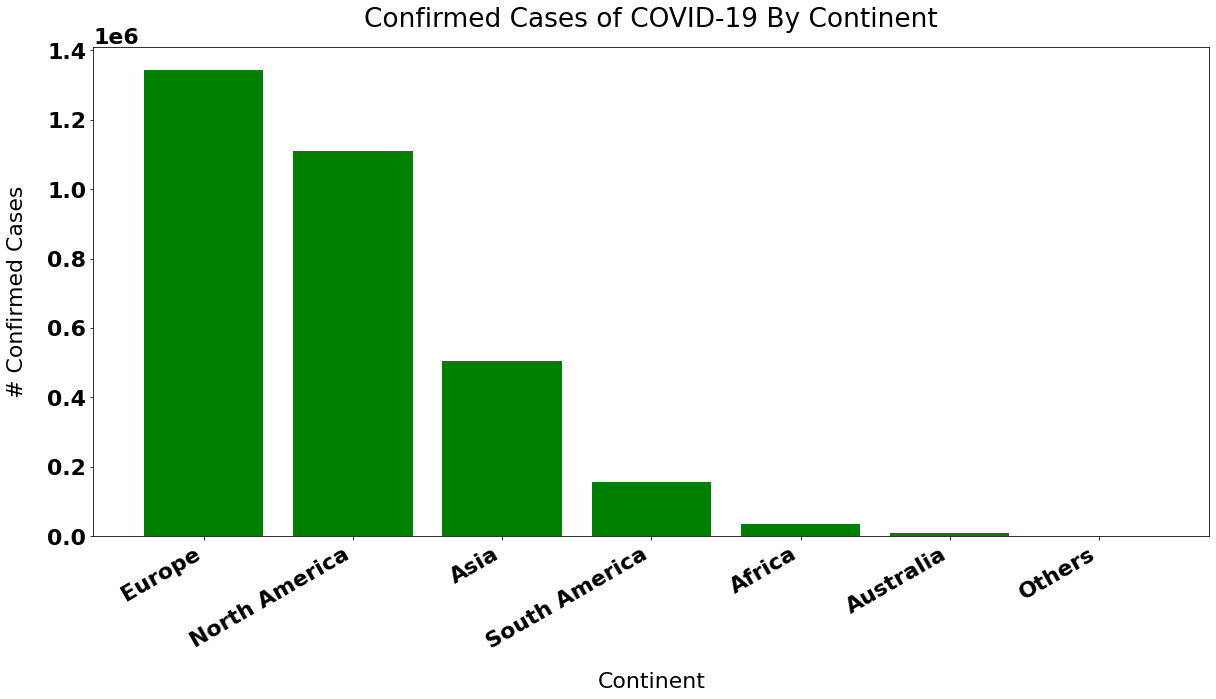

In [9]:
plot_bar(df_continents,dimensions='Continent',measure='Confirmed',x_axis='Continent',y_axis='# Confirmed Cases',title='Confirmed Cases of COVID-19 By Continent',color='g')

Figure 2

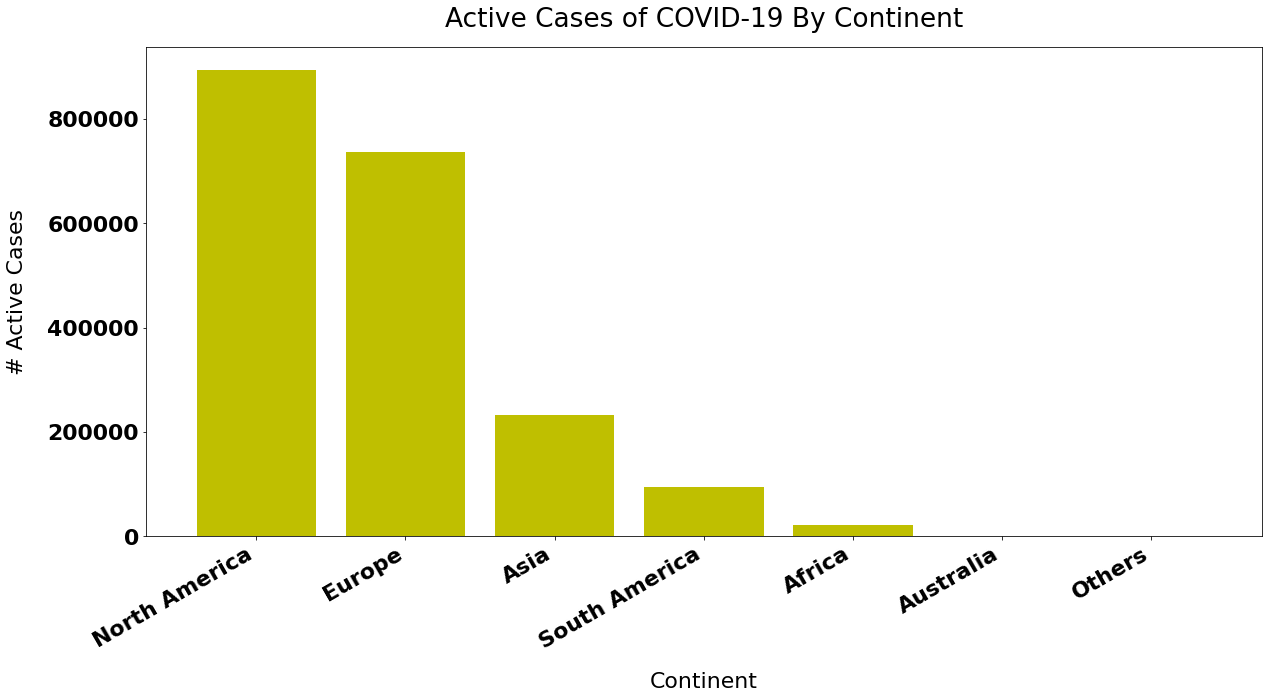

In [10]:
plot_bar(df_continents,dimensions='Continent',measure='Active',x_axis='Continent',y_axis='# Active Cases',title='Active Cases of COVID-19 By Continent',color='y')

Figure 3

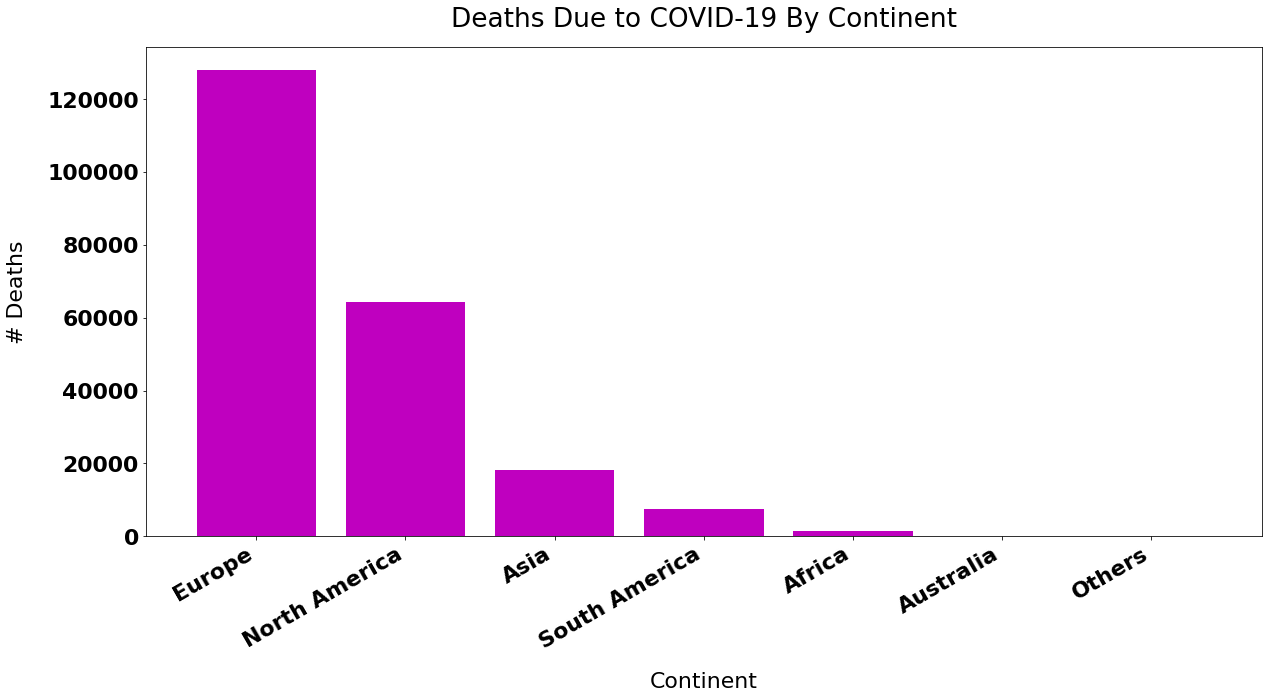

In [11]:
plot_bar(df_continents,dimensions='Continent',measure='Deaths',x_axis='Continent',y_axis='# Deaths',title='Deaths Due to COVID-19 By Continent',color='m')

Figure 4

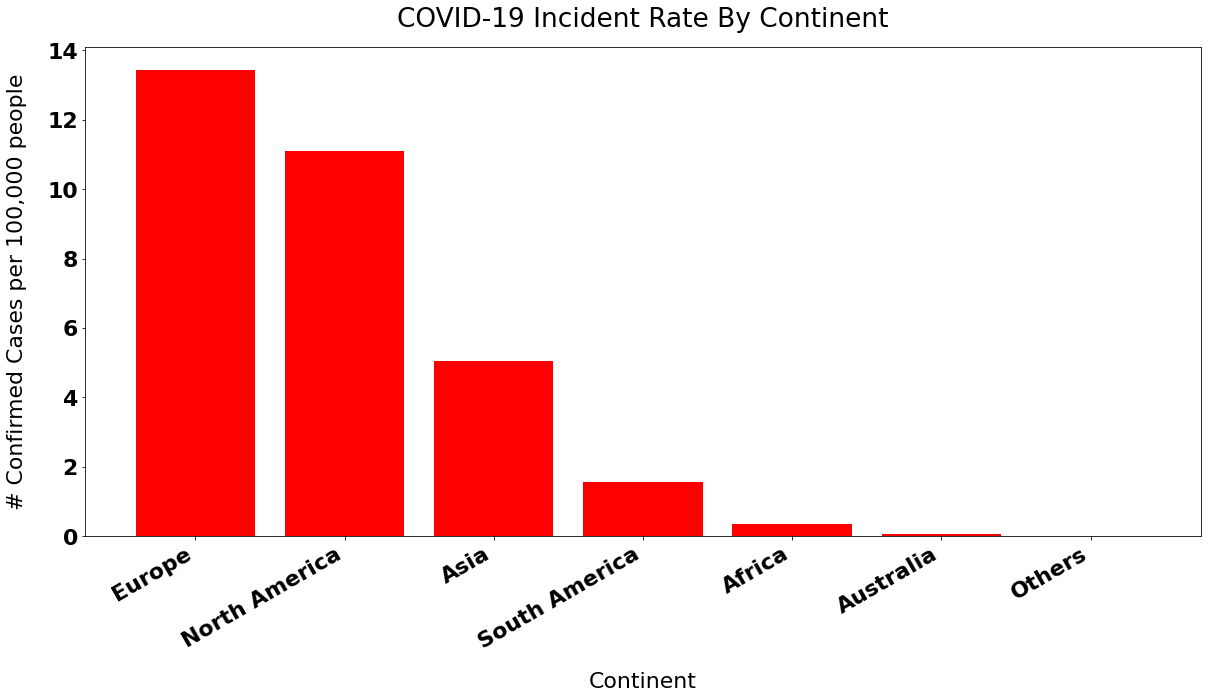

In [12]:
plot_bar(df_continents,dimensions='Continent',measure='Incident_Rate',x_axis='Continent',y_axis='# Confirmed Cases per 100,000 people',title='COVID-19 Incident Rate By Continent',color='r')

Figure 5

In [ ]:
# <!-- Table 1: Latest COVID-1 Statistics (Continent-wise) -->

In [34]:
# style(df_continents,sortby='Confirmed')

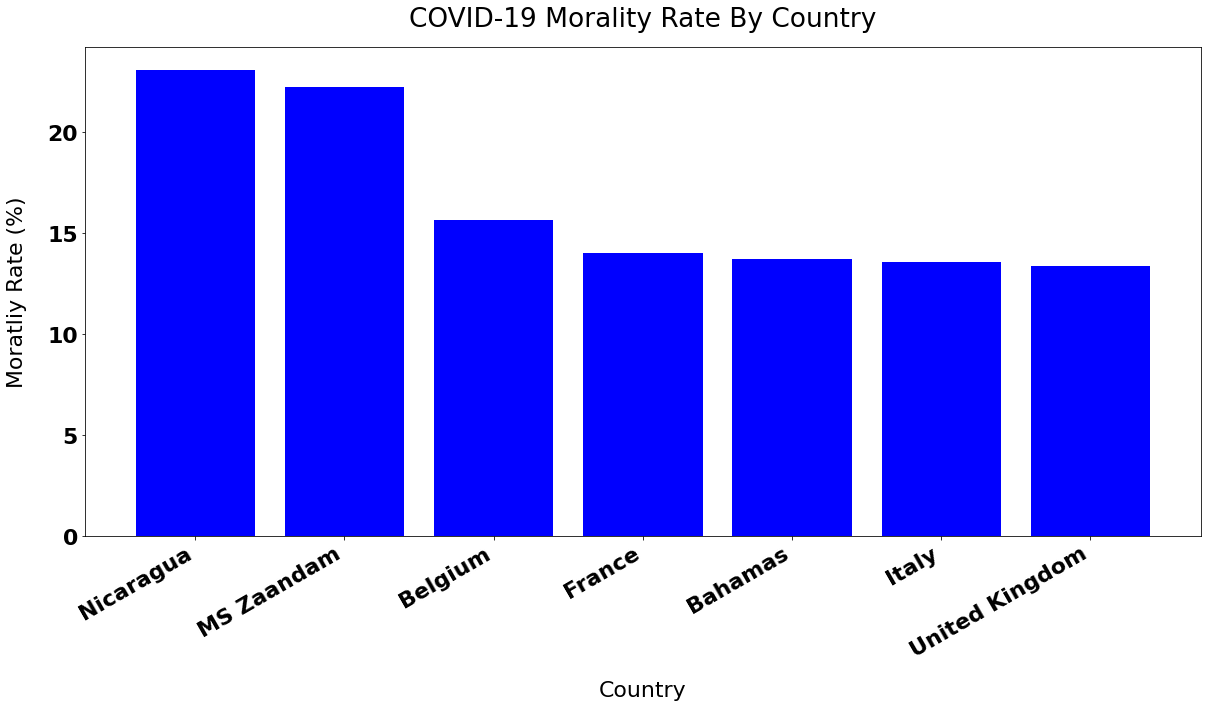

In [14]:
# Create bar charts expressing the latest COVID-19 statistics for each country
# Show only the most 7 affected countries for each statistic
df_countries = generate(df_covid_latest,dimension='Country')
plot_bar(df_countries,dimensions='Country',measure='Mortality_Rate',x_axis='Country',y_axis='Moratliy Rate (%)',title='COVID-19 Morality Rate By Country',color='b')


Figure 6

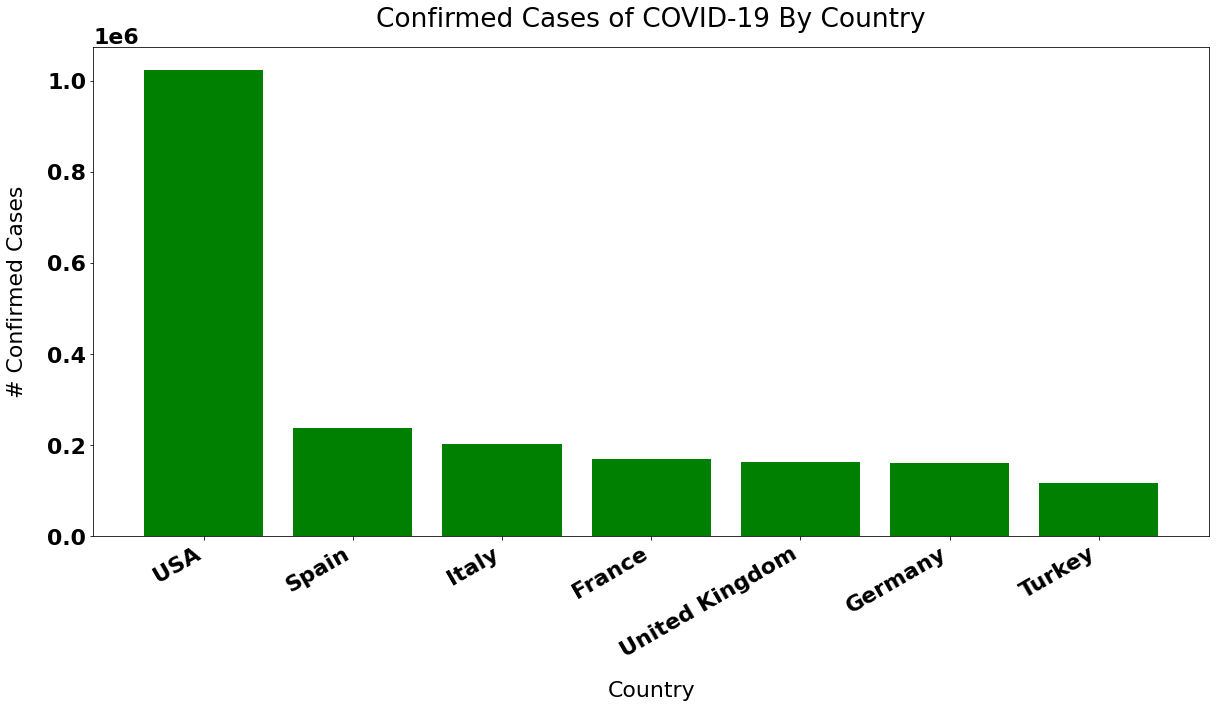

In [15]:
plot_bar(df_countries,dimensions='Country',measure='Confirmed',x_axis='Country',y_axis='# Confirmed Cases',title='Confirmed Cases of COVID-19 By Country',color='g')

Figure 7

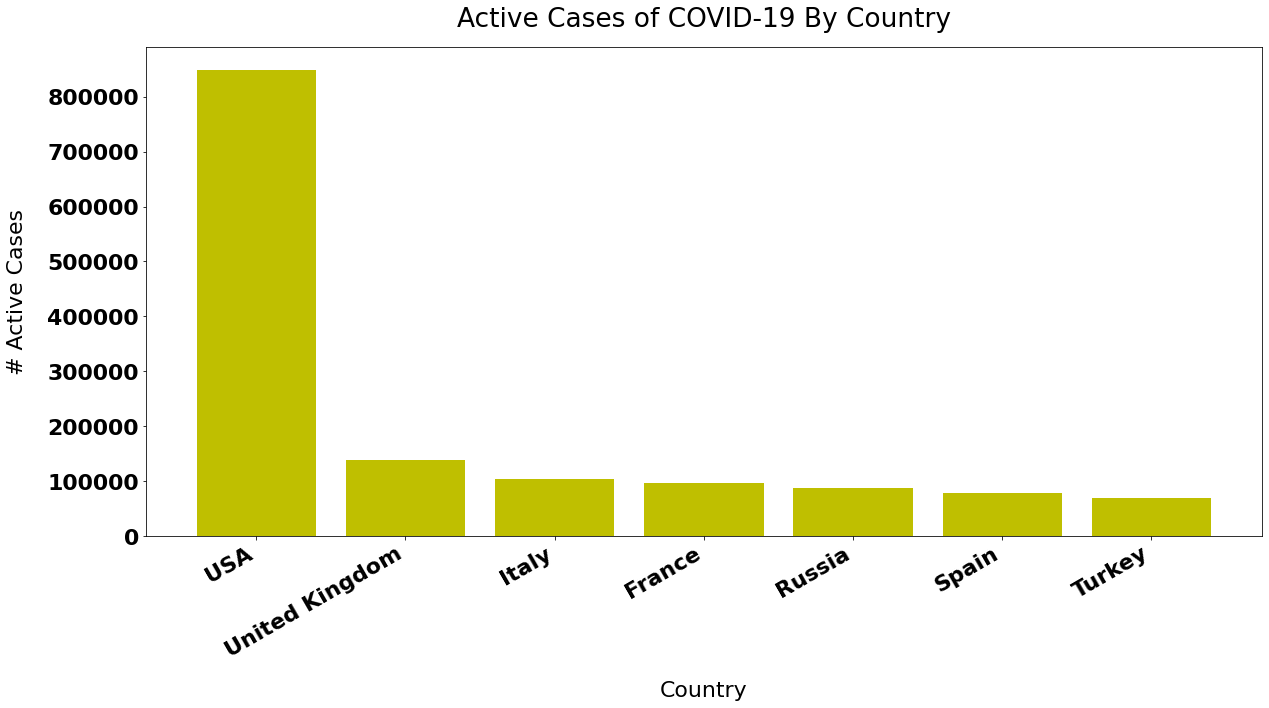

In [16]:
plot_bar(df_countries,dimensions='Country',measure='Active',x_axis='Country',y_axis='# Active Cases',title='Active Cases of COVID-19 By Country',color='y')

Figure 8

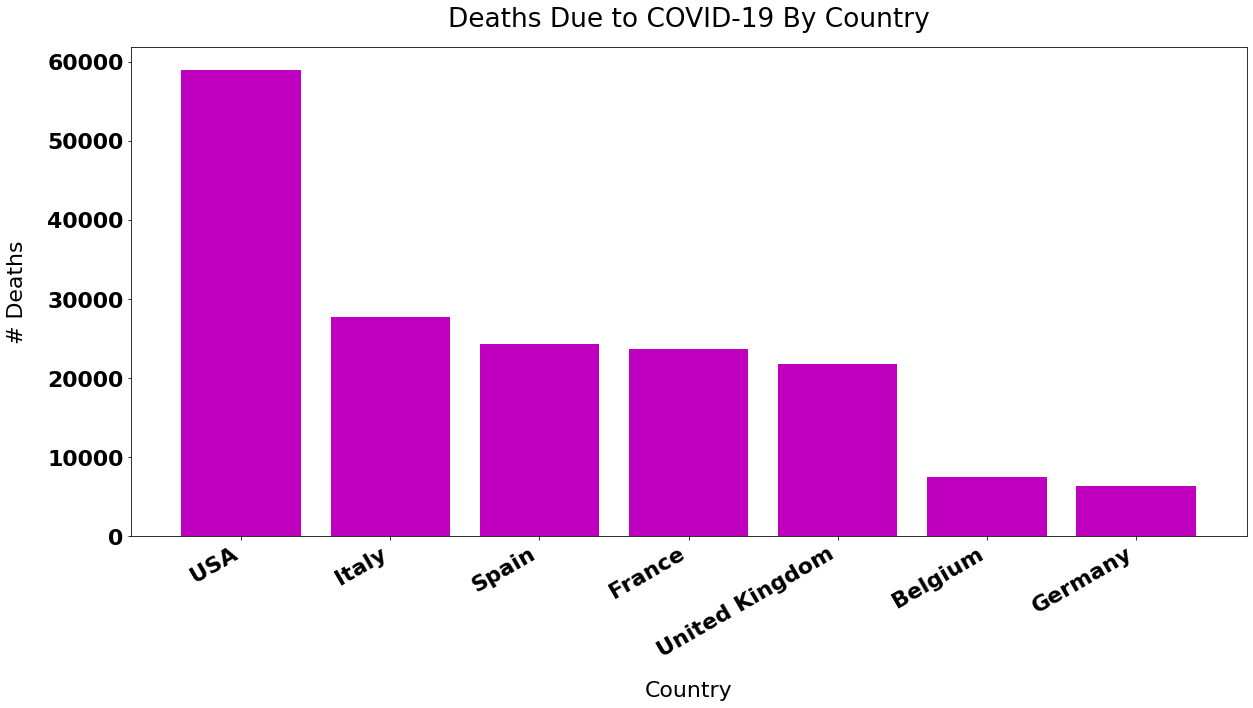

In [17]:
plot_bar(df_countries,dimensions='Country',measure='Deaths',x_axis='Country',y_axis='# Deaths',title='Deaths Due to COVID-19 By Country',color='m')

Figure 9

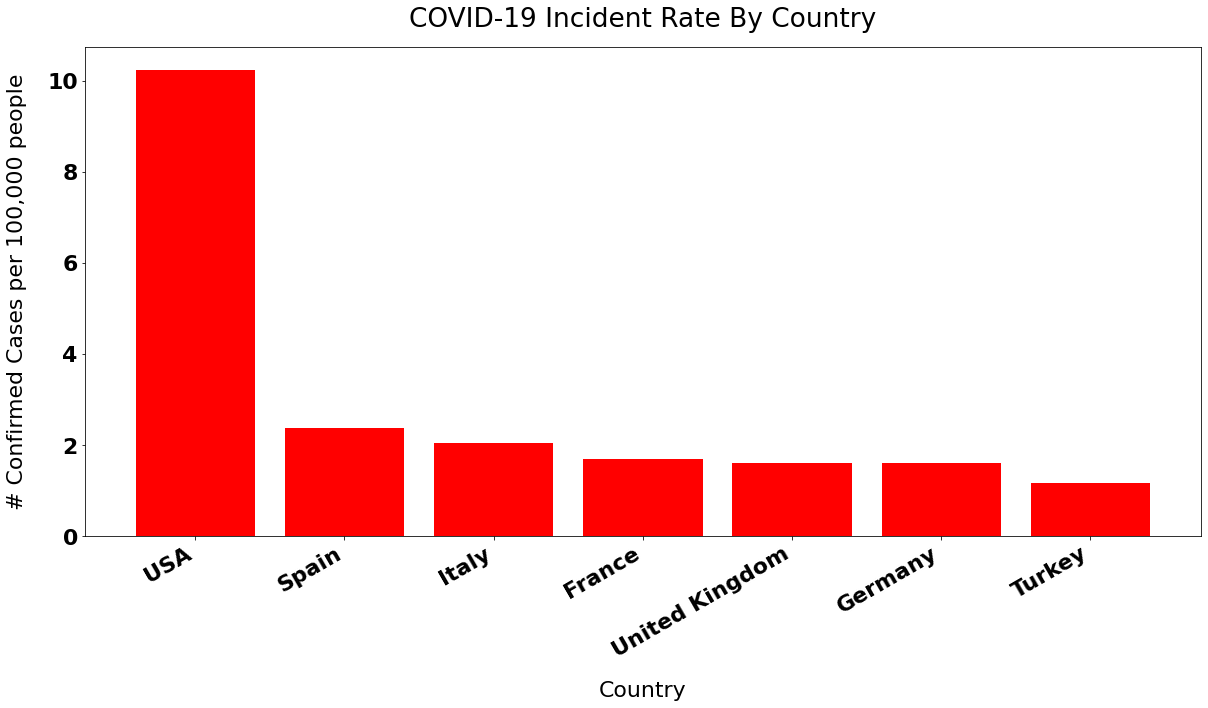

In [18]:
plot_bar(df_countries,dimensions='Country',measure='Incident_Rate',x_axis='Country',y_axis='# Confirmed Cases per 100,000 people',title='COVID-19 Incident Rate By Country',color='r')

Figure 10

In [37]:
# <!-- Table 2: Latest COVID-1 Statistics (Country-wise) -->

In [38]:
# style(df_countries.head(20),sortby='Confirmed')

## Basic Timeseries Plots

In [20]:
# Plot timeseries data as a line plot
def plot_line(dataframe,title='COVID-19 Cases Over Time: Globally',x_axis='Date',y_axis='Daily Cases'):
    dataframe.dropna(axis=0,inplace=True)
    dates = [datetime.datetime.strptime(str(date), '%m/%d/%y') for date in dataframe.index]

    fig, ax = plt.subplots()
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    days = mdates.DayLocator()
    # years_fmt = mdates.DateFormatter('%Y')
    
    for column in dataframe.columns:
        ax.plot(dates,dataframe[column],label=f"{column} cases")
    ax.legend(loc="upper left")
    # format the ticks
    # ax.xaxis.set_major_locator(years)
    # ax.xaxis.set_major_formatter(years_fmt)
    # ax.xaxis.set_major_locator(months)
    # ax.xaxis.set_minor_locator(days)
    
    ax.set_ylabel(y_axis,labelpad=20)
    ax.set_title(title,pad=20)
    ax.set_xlabel(x_axis,labelpad=20)

    # round to nearest years.
    datemin = np.datetime64(dates[0], 'M')
    datemax = np.datetime64(dates[-1], 'M') + np.timedelta64(1, 'M')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.format_ydata = lambda x: '%1.2f' % x  # format the price.
    ax.grid(True)

    fig.autofmt_xdate()

In [21]:
# Utility function of make_dataframe
# used to preprocess timeseries data such that it can be combined
# with other timeseries data
# Location type can be either continent or country at this time
def make_series(dataframe,name,location_type=None,location=None):
    if location_type == None:
        series = pd.Series(dataframe.drop(['state','Continent','Country','Lat','Long'],axis=1).sum(),name=name)
    else:
        series = pd.Series(dataframe[dataframe[location_type] == location].drop(['state','Continent','Country','Lat','Long'],axis=1).sum(),name=name)
    series.dropna(axis=0,inplace=True)
    return series

# Create a dataframe that encompasses all timeseries
# data: i.e. confirmed cases, deaths, recovered cases
def make_dataframe(dataframes,columns,location_type=None,location=None):
    series_list = []
    for (d,c) in zip(dataframes,columns):
        series_list.append(make_series(d,c,location_type,location))
    dataframe = pd.concat(series_list, axis=1)
    return dataframe
        

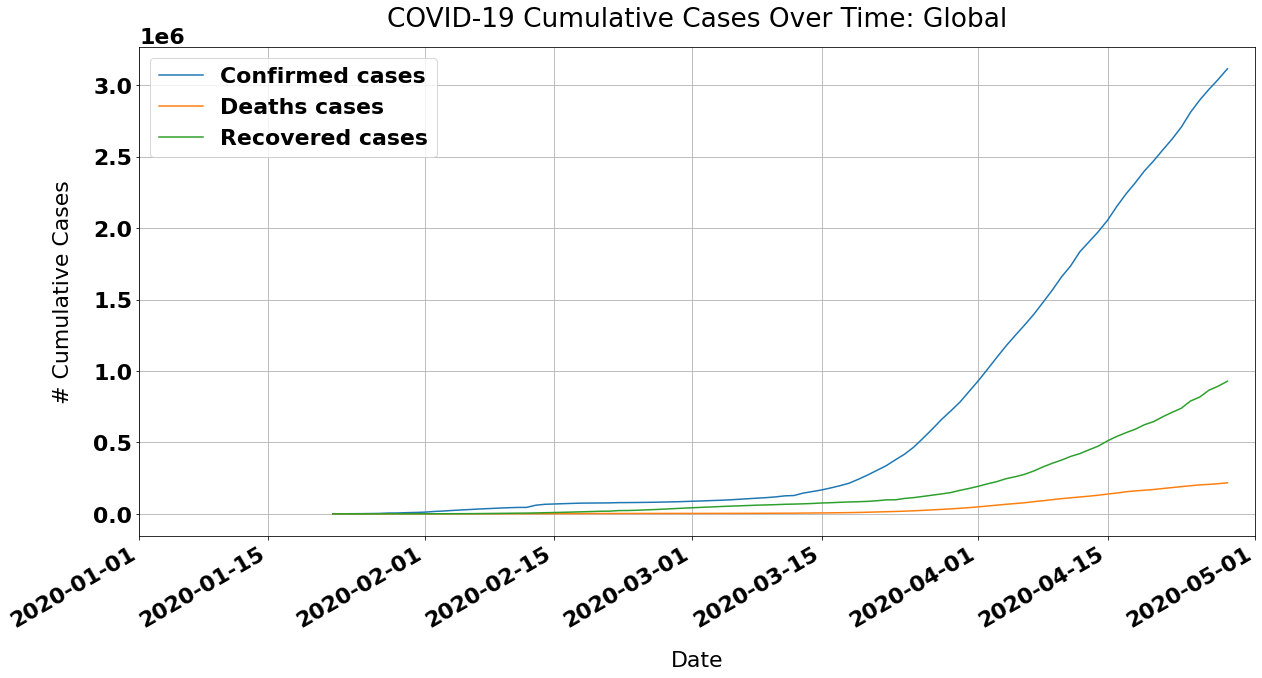

In [22]:
global_timeseries_data = make_dataframe([df_confirmed,df_deaths,df_recovered],['Confirmed','Deaths','Recovered'])
plot_line(global_timeseries_data,title='COVID-19 Cumulative Cases Over Time: Global',x_axis='Date',y_axis='# Cumulative Cases')


Figure 11

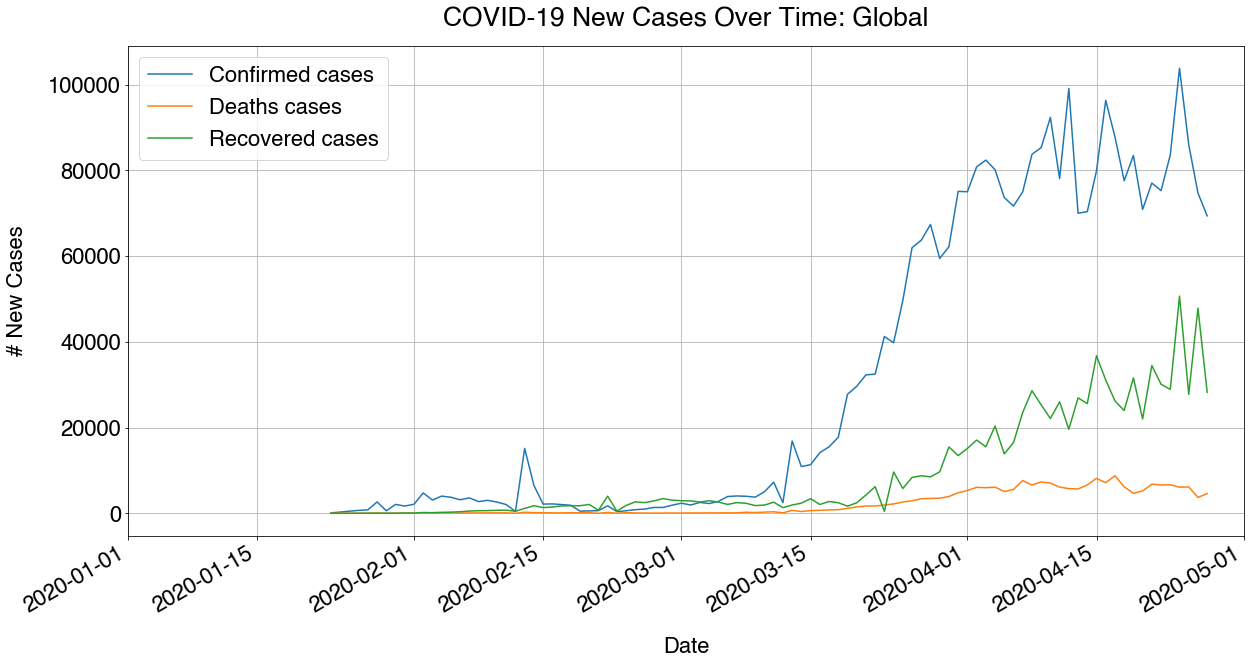

In [24]:
plot_line(global_timeseries_data.diff(),title='COVID-19 New Cases Over Time: Global',x_axis='Date',y_axis='# New Cases')

Figure 12

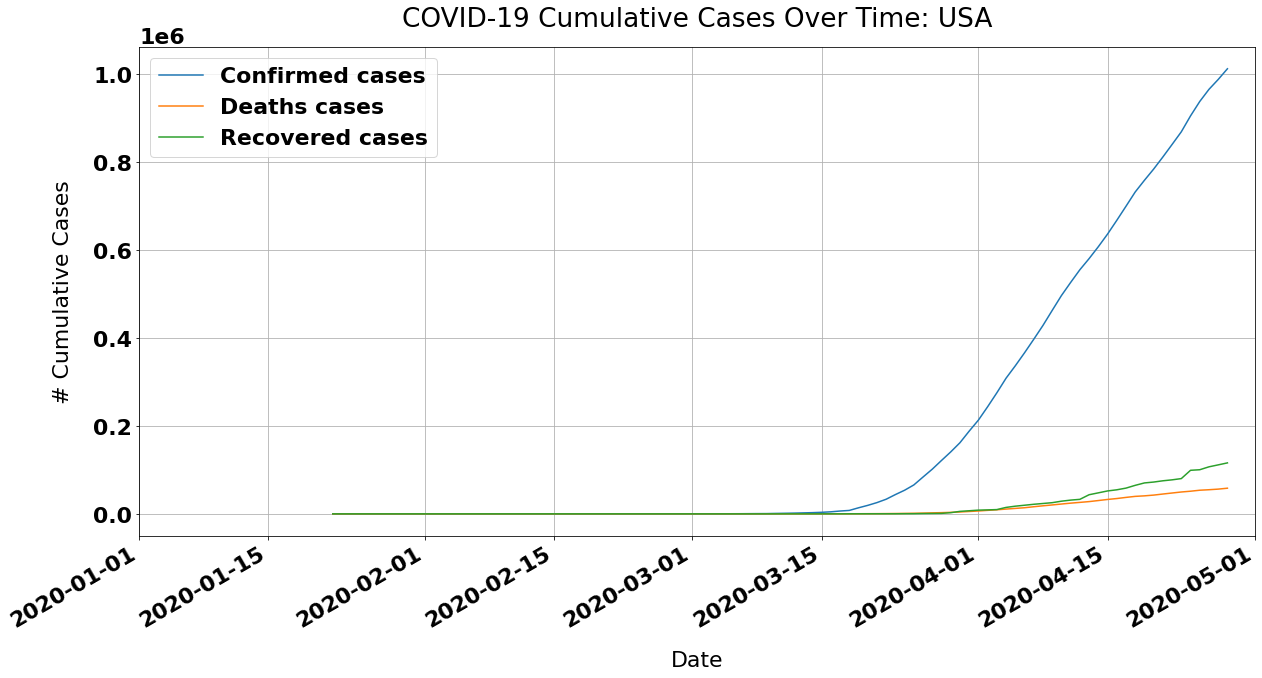

In [23]:
usa_timeseries_data = make_dataframe([df_confirmed,df_deaths,df_recovered],['Confirmed','Deaths','Recovered'],'Country','USA')
plot_line(usa_timeseries_data,title='COVID-19 Cumulative Cases Over Time: USA',x_axis='Date',y_axis='# Cumulative Cases')


Figure 13

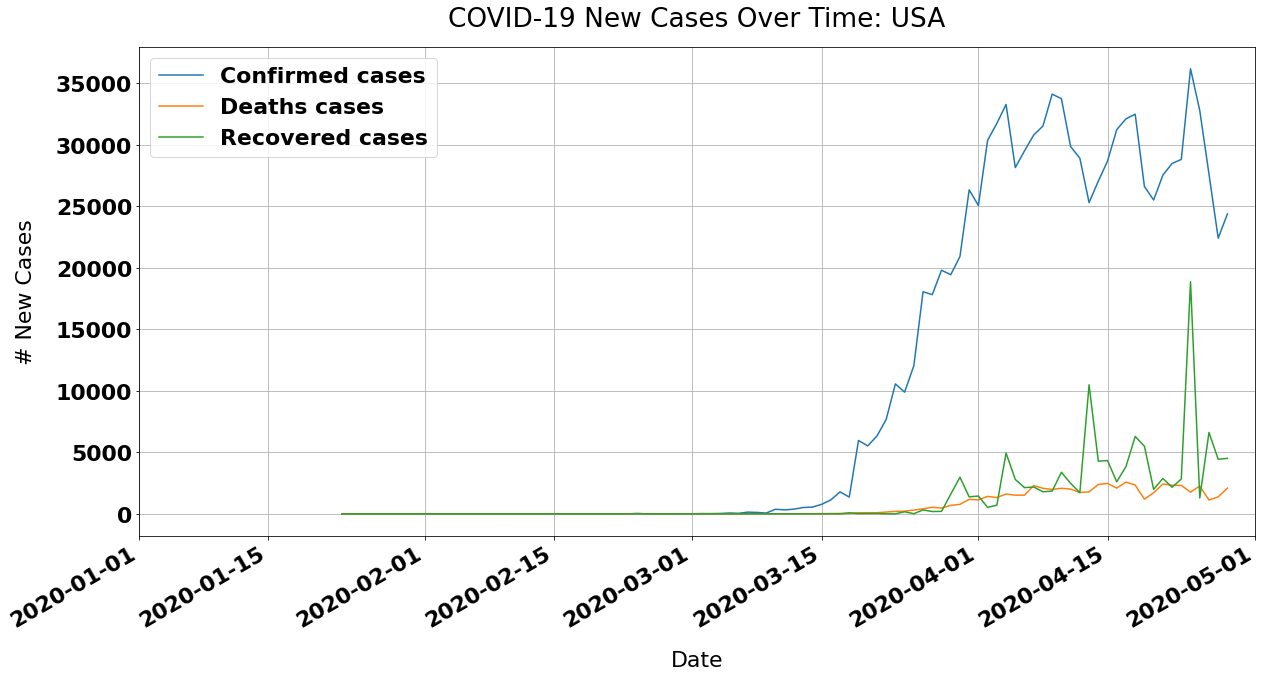

In [24]:
plot_line(usa_timeseries_data.diff(),title='COVID-19 New Cases Over Time: USA',x_axis='Date',y_axis='# New Cases')

Figure 14

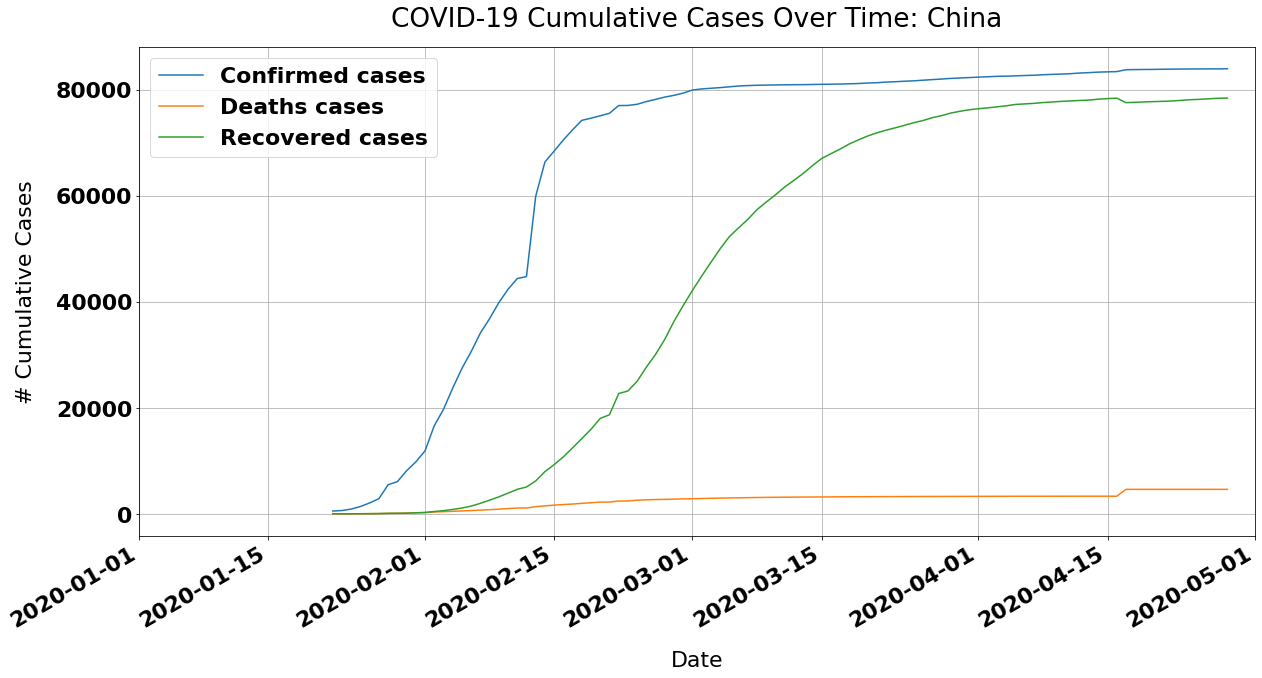

In [25]:
china_timeseries_data = make_dataframe([df_confirmed,df_deaths,df_recovered],['Confirmed','Deaths','Recovered'],'Country','China')
plot_line(china_timeseries_data,title='COVID-19 Cumulative Cases Over Time: China',x_axis='Date',y_axis='# Cumulative Cases')


Figure 15

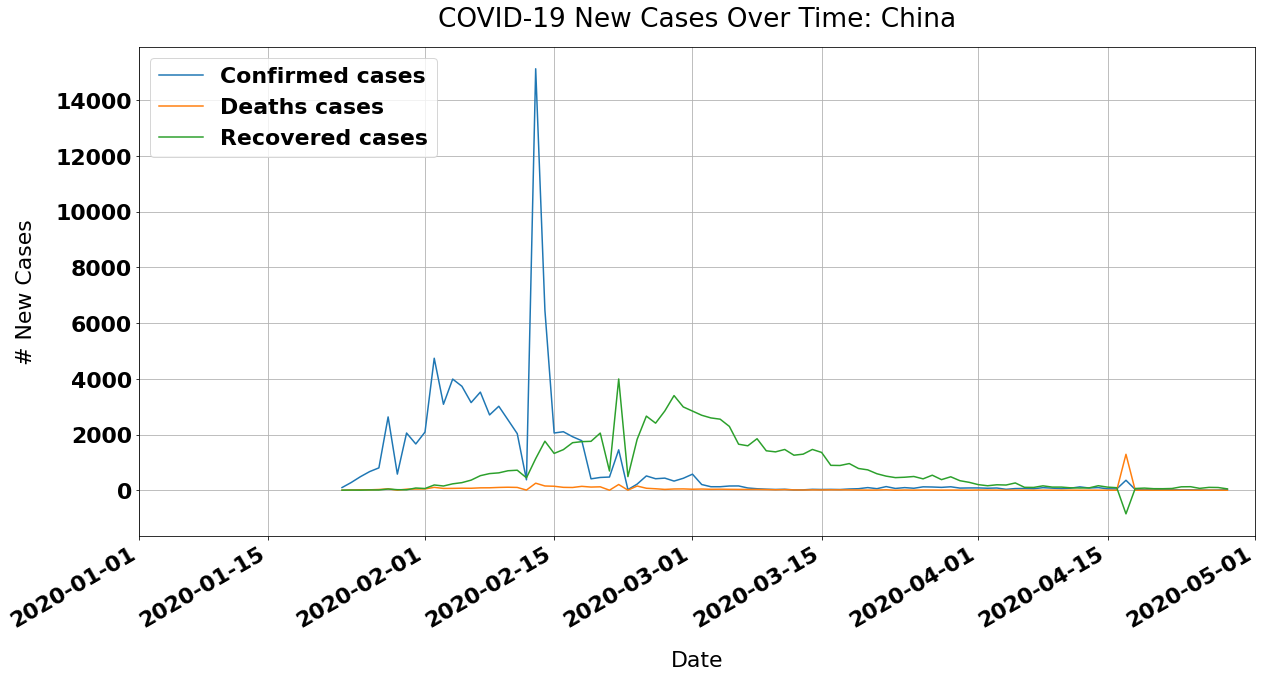

In [26]:
plot_line(china_timeseries_data.diff(),title='COVID-19 New Cases Over Time: China',x_axis='Date',y_axis='# New Cases')

Figure 16

## Choropleth Maps

In [27]:
def create_choropleth_map(dataframe,variable,title='COVID-19 Cases Over Time: Globally',x_axis='Date',y_axis='Daily Cases'):
    fig, ax = plt.subplots(1, 1)
    ax.set_ylabel(y_axis,labelpad=20)
    ax.set_title(title,pad=20)
    ax.set_xlabel(x_axis,labelpad=20)
    gdf = geopandas.GeoDataFrame(dataframe)
    gdf.plot(column=variable,ax=ax)

In [28]:
# Inner Join Two DataFrames
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
mapping = {'United States of America':'USA',\
           'Dem. Rep. Congo':'Democratic Republic of the Congo',\
           'Central African Rep.':'Central African Republic',\
           'Congo':'Republic of the Congo',\
           'Bosnia and Herz.':'Bosnia',\
           'Eq. Guinea':'Equatorial Guinea',\
           'S. Sudan':'South Sudan'\
          }
world.replace(mapping,inplace=True)
gdf = pd.merge(left=df_covid_latest, right=world, left_on='Country', right_on='name')

In [29]:
## Figure out which countries have to be manually mapped between the 
## COVID dataframe and naturalearth_lowres dataframe
# gdf_tmp = pd.merge(left=df_covid_latest, right=world, left_on='Country', right_on='name',how='outer')[['Country','name']]
# gdf_tmp = gdf_tmp[gdf_tmp.isnull().any(axis=1)]
# [print(row) for row in gdf_tmp.itertuples()]

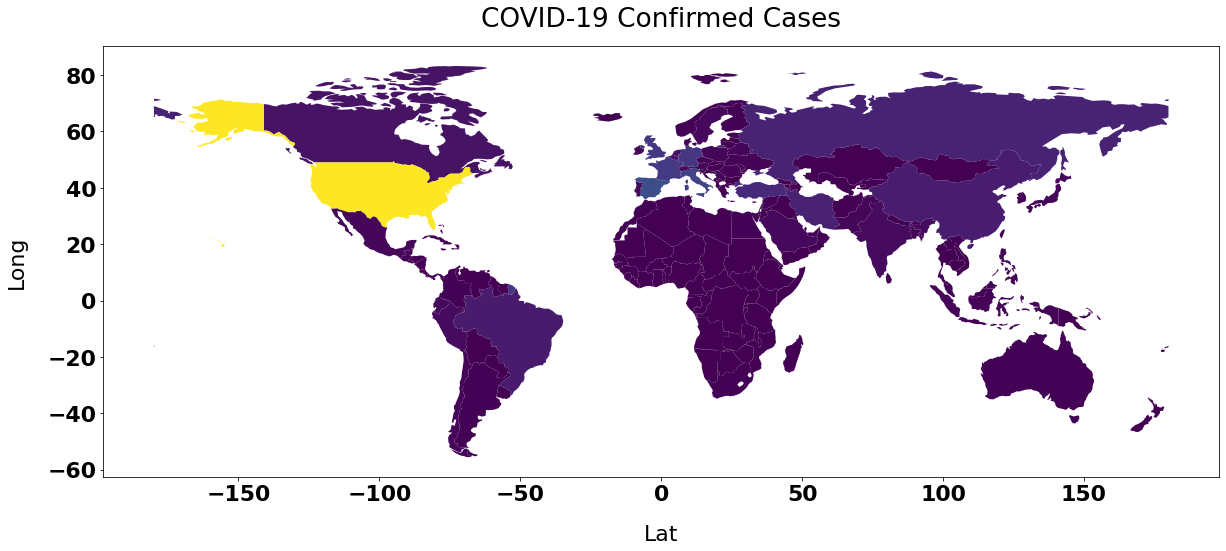

In [30]:
create_choropleth_map(gdf,'Confirmed',title='COVID-19 Confirmed Cases',x_axis='Lat',y_axis='Long')

Figure 17

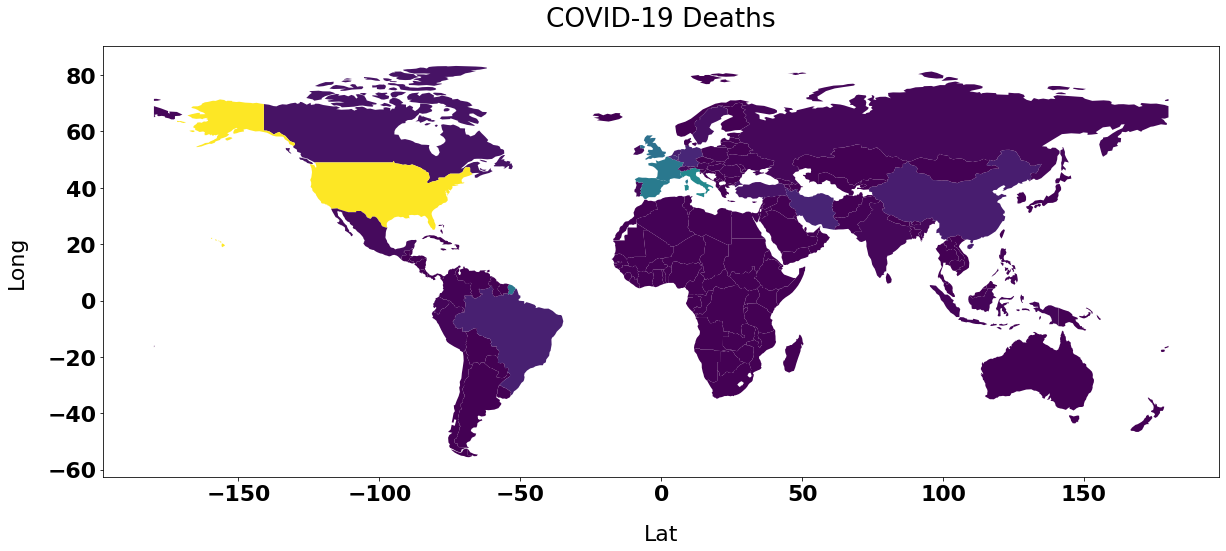

In [31]:
create_choropleth_map(gdf,'Deaths',title='COVID-19 Deaths',x_axis='Lat',y_axis='Long')

Figure 18

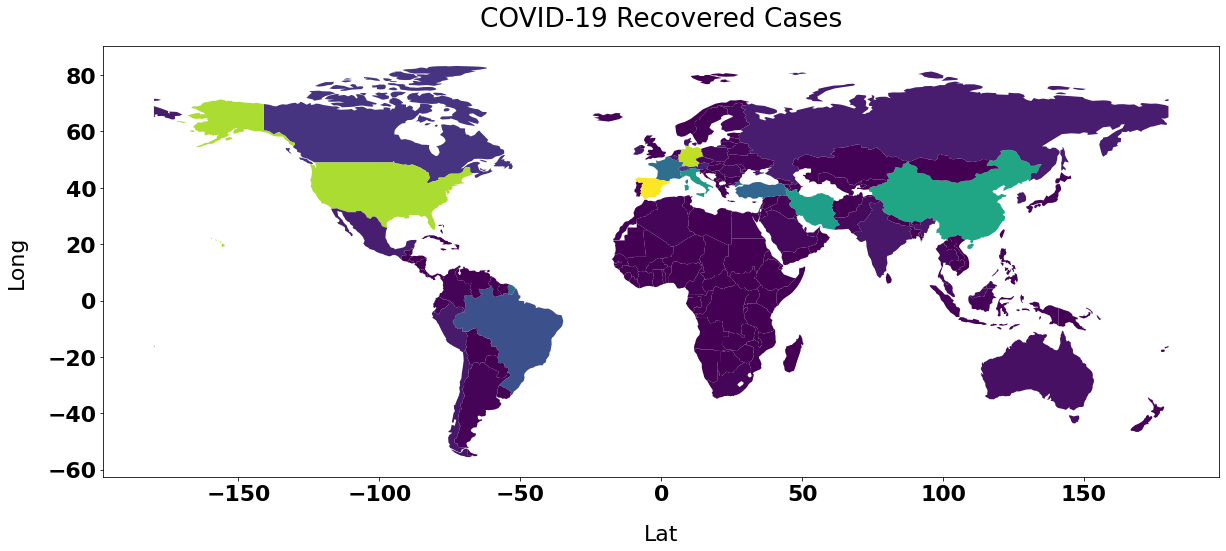

In [32]:
create_choropleth_map(gdf,'Recovered',title='COVID-19 Recovered Cases',x_axis='Lat',y_axis='Long')

Figure 19